# Thinking Like Transformers

[Paper on arXiv](https://arxiv.org/abs/2106.06981)

Notebook author: Polina Guseva

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

## Training setup

In [2]:
import math


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0., max_len=512):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer("pe", pe)

    def forward(self, x):
        embedding = self.pe[:x.size(0), :]
        x = x + embedding
        return self.dropout(x)


class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=512):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_forwards = d_model
        self.forwards_embedding = nn.Embedding(max_len, self.d_forwards)

    def forward(self, x, real_lengths=None):
        seq_len = x.shape[0]
        def make_indices_tensor(indices):
            res = torch.LongTensor([indices]).transpose(0,1)
            if next(self.parameters()).is_cuda:  res = res.cuda()
            return res
        x[:,:,:self.d_forwards]+= self.forwards_embedding(make_indices_tensor(list(range(seq_len))))
        return self.dropout(x)


class FullEmbedding(nn.Module):

    def __init__(self, d_model, num_tokens, max_len,
                       positional_encoding_type, positional_dropout):
        super(FullEmbedding,self).__init__()

        position_modules = {"sin":PositionalEncoding,
                            "embed":PositionalEmbedding}
        position_module = position_modules[positional_encoding_type]

        positional_encoding = position_module(d_model,positional_dropout,
            max_len=max_len)
        
        word_embedding = nn.Embedding(num_tokens, d_model)

        self.word = word_embedding
        self.pos = positional_encoding
        self.max_len = max_len

    def forward(self,x,real_lengths=None):
        res = self.word(x)
        return self.pos(res)

In [20]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, d_model, heads, layers, dim_feedforward, out_size):
        super().__init__()

        self.emb = FullEmbedding(d_model, vocab_size, 100, "sin", 0.)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, heads, dim_feedforward, activation="relu", batch_first=True, dropout=0.
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, layers)

        self.projection = nn.Linear(d_model, out_size)
    
        self.is_classifier = out_size > 1
    
    def task_type(self):
        if self.is_classifier:
            return "classification"
        return "regression"

    def forward(self, x):
        x = self.emb(x)
        out = self.encoder(x)
        out = self.projection(out)
        if not self.is_classifier:
            out = out.squeeze(-1)
        return out

In [128]:
class Trainer:

    def __init__(self, model, optimizer, device,
                 train_dataloader, val_dataloader, scheduler, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.cur_epoch = 1
        self.num_epochs = kwargs.get("num_epochs", 10)

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

        self.max_gradient_norm = kwargs.get("max_gradient_norm", 3.0)

        self.log_step = 100

        self.device = device
    
    @staticmethod
    def move_to_device(batch, device):
        for key in ["src", "tgt"]:
            batch[key] = batch[key].to(device)
        return batch

    def train(self):
        start_epoch = self.cur_epoch
        for epoch in range(start_epoch, self.num_epochs + 1):
            self._train_epoch(epoch)
            self.cur_epoch += 1
            if self.scheduler is not None:
                self.scheduler.step()
    
    def process_batch(self, batch, is_training):
        batch = self.move_to_device(batch, self.device)
    
        outputs = self.model(batch["src"])
        
        if self.model.task_type() == "classification":
            loss = F.cross_entropy(outputs.transpose(1, 2), batch["tgt"])

        else:
            loss = F.mse_loss(outputs, batch["tgt"].float())
        
        if is_training:
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), self.max_gradient_norm)
            self.optimizer.step()

        preds = outputs.detach()
        if self.model.task_type() == "classification":
            preds = preds.argmax(dim=-1)
        else:
            preds = torch.round(preds)

        return loss, preds

    def _train_epoch(self, epoch):
        self.model.train()
        for batch_idx, batch in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            loss, preds = self.process_batch(batch, is_training=True)

            if batch_idx % self.log_step == 0:
                acc = (preds == batch["tgt"]).float().mean()
                print(
                    "TRAIN (epoch {}, batch {}) - accuracy {:.4f} - loss {:.4f} - grad norm {:.4f}".format(
                        epoch, batch_idx, acc, loss, self.get_grad_norm()
                ))
        
        self._valid_epoch(epoch)

    def _valid_epoch(self, epoch):
        self.model.eval()
        sum_correct = 0
        sum_loss = 0.
        num_datapoints = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(self.val_dataloader):
                loss, preds = self.process_batch(batch, is_training=False)

                batch_size = preds.size(0) * preds.size(1)
                sum_correct += (preds == batch["tgt"]).float().sum()
                sum_loss += loss * batch_size
                num_datapoints += batch_size
            
            print("VALID (epoch {}) - accuracy {:.4f} - loss {:.4f}".format(
                epoch, sum_correct / num_datapoints, sum_loss / num_datapoints
            ))
    
    @torch.no_grad()
    def get_grad_norm(self):
        params = [p for p in self.model.parameters() if p.grad is not None]
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), p=2).cpu() for p in params]), p=2)
        return total_norm.item()

## Replication


For simplicity, we are going to work with sequences that have the same fixed length.

In [6]:
SEED = 42

In [7]:
import random


def set_seed(seed):
    np.random.seed(seed)
    
    random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Datasets

In [8]:
import string

In [9]:
def generate_data(rng, dataset_size, alphabet_size, seq_len, out_filepath):
    assert 0 < alphabet_size <= 26

    alphabet = list(string.ascii_lowercase[:alphabet_size])
    with open(out_filepath, "w") as out_file:
        for _ in range(dataset_size):
            seq = rng.choice(alphabet, size=seq_len)
            seq = "".join(seq)
            out_file.write(seq)
            out_file.write("\n")

In [10]:
TRAIN_SIZE = 10_000
VAL_SIZE = 1_000
TEST_SIZE = 1_000

ALPHABET_SIZE = 8
SEQ_LEN = 20

rng = np.random.default_rng(SEED)

generate_data(rng, TRAIN_SIZE, ALPHABET_SIZE, SEQ_LEN, f"train_a{ALPHABET_SIZE}_seq{SEQ_LEN}.txt")
generate_data(rng, VAL_SIZE, ALPHABET_SIZE, SEQ_LEN, f"val_a{ALPHABET_SIZE}_seq{SEQ_LEN}.txt")
generate_data(rng, TEST_SIZE, ALPHABET_SIZE, SEQ_LEN, f"test_a{ALPHABET_SIZE}_seq{SEQ_LEN}.txt")

In [11]:
import linecache

In [12]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, datafile, tgt_transform, bos_id=None):
        super().__init__()

        self.datafile = datafile
        self.tgt_transform = tgt_transform

        self.bos_id = bos_id

        self.dataset_size = 0
        with open(self.datafile) as f:
            for _ in f:
                self.dataset_size += 1
    
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        src = linecache.getline(self.datafile, idx + 1).strip()
        src = list(map(lambda x: string.ascii_lowercase.index(x), src))

        tgt = self.tgt_transform(src)

        if self.bos_id is not None:
            src = [self.bos_id] + src
            tgt = [self.bos_id] + tgt + ([self.bos_id] * (len(src) - len(tgt) - 1))

        return {
            "src": src,
            "tgt": tgt,
        }

In [13]:
def collate_fn(batch):
    result = dict()
    for key in ["src", "tgt"]:
        result[key] = torch.cat(
            [torch.LongTensor(item[key]).unsqueeze(0) for item in batch], dim=0
        )

    return result

In [44]:
def test_eval(filepath, transform_func, model, device):
    dataset = SequenceDataset(filepath, transform_func)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    model.eval()
    sum_correct = 0
    sum_loss = 0
    num_datapoints = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            batch = Trainer.move_to_device(batch, device)

            outputs = model(batch["src"])

            if model.task_type() == "classification":
                loss = F.cross_entropy(outputs.transpose(1, 2), batch["tgt"])

            else:
                loss = F.mse_loss(outputs, batch["tgt"].float())

            preds = outputs.detach()
            if model.task_type() == "classification":
                preds = preds.argmax(dim=-1)
            else:
                preds = torch.round(preds)

            batch_size = preds.size(0) * preds.size(1)
            sum_correct += (preds == batch["tgt"]).float().sum()
            sum_loss += loss * batch_size
            num_datapoints += batch_size
    
    return sum_correct / num_datapoints, sum_loss / num_datapoints

### Tools for extracting attention maps

In [84]:
class OutputHook:
    def __init__(self, name):
        self.saved_outs = []
        self.name = name

    def __call__(self, module, input, output):
        self.saved_outs.append(output[1].detach().cpu())

In [81]:
def add_hooks(model):
    hooks = dict()
    handles = []
    for layer_id, layer in enumerate(model.encoder.layers):
        name = f"l{layer_id}"
        hook = OutputHook(name)
        hooks[name] = hook
        handles.append(layer.self_attn.register_forward_hook(hook))

    return hooks, handles

def remove_hooks(hook_handles):
    for handle in hook_handles:
        handle.remove()

### Histograms

In [34]:
set_seed(SEED)

In [35]:
model = Encoder(ALPHABET_SIZE, 256, 1, 1, 512, 1)

optim = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = None

In [36]:
def hist(x):
    _, inv, cnt = np.unique(x, return_inverse=True, return_counts=True)
    return list(cnt[inv])

In [37]:
BATCH_SIZE = 32

train_dataset = SequenceDataset("train_a8_seq20.txt", hist)
val_dataset = SequenceDataset("val_a8_seq20.txt", hist)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
model = model.to(device)

trainer = Trainer(
    model, 
    optim,
    device, 
    train_dataloader,
    val_dataloader,
    scheduler,
    max_gradient_norm=10.,
    num_epochs=50,
)

trainer.train()

TRAIN (epoch 1, batch 0) - accuracy 0.0203 - loss 10.1641 - grad norm 10.0000
TRAIN (epoch 1, batch 100) - accuracy 0.3531 - loss 1.5386 - grad norm 5.5502
TRAIN (epoch 1, batch 200) - accuracy 0.4203 - loss 1.2735 - grad norm 10.0000
TRAIN (epoch 1, batch 300) - accuracy 0.4375 - loss 1.3563 - grad norm 6.3124
VALID (epoch 1) - accuracy 0.4691 - loss 1.0919
TRAIN (epoch 2, batch 0) - accuracy 0.4672 - loss 0.8027 - grad norm 10.0000
TRAIN (epoch 2, batch 100) - accuracy 0.5078 - loss 0.9968 - grad norm 10.0000
TRAIN (epoch 2, batch 200) - accuracy 0.4719 - loss 1.0750 - grad norm 9.4165
TRAIN (epoch 2, batch 300) - accuracy 0.4437 - loss 1.2627 - grad norm 6.0833
VALID (epoch 2) - accuracy 0.5237 - loss 1.0111
TRAIN (epoch 3, batch 0) - accuracy 0.5375 - loss 0.7004 - grad norm 8.0226
TRAIN (epoch 3, batch 100) - accuracy 0.5203 - loss 0.9320 - grad norm 8.6834
TRAIN (epoch 3, batch 200) - accuracy 0.4719 - loss 1.0584 - grad norm 8.5109
TRAIN (epoch 3, batch 300) - accuracy 0.4437 - 

Paper states that on Hist language upper bound is (1, 2). With 1 layer and 2 heads transformer is able to reach accuracy 99.9, but with 1 layer and 1 head one can only reach accuracy of 91.9.

The experiment shows that transformer with L=1, H=1 is capable of learning Hist language, hence the claim in the paper is false. It is possible that hyperparameters in paper aren't well optimized.

In [45]:
acc, loss = test_eval("test_a8_seq20.txt", hist, model, device)

"TEST acc {:.4f} - loss {:.4f}".format(acc, loss)

'TEST acc 1.0000 - loss 0.0013'

Also let's look at attention map

In [88]:
hooks, handles = add_hooks(model)

seq = np.random.choice(np.arange(ALPHABET_SIZE), size=SEQ_LEN)

model(torch.LongTensor([seq]).to("cuda"))

remove_hooks(handles)

In [92]:
attention_map = hooks["l0"].saved_outs[0].squeeze(0)

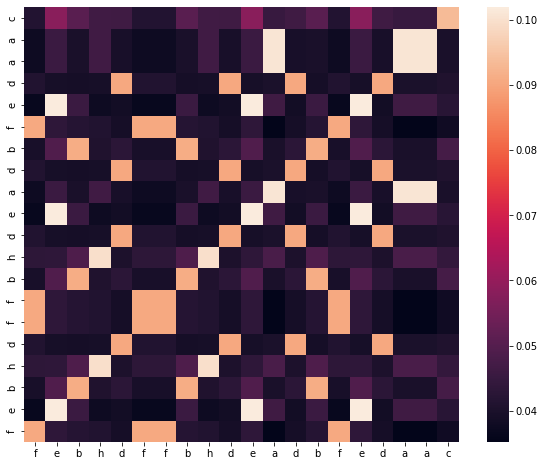

In [98]:
plt.figure(figsize=(10, 8))

decoded_seq = [string.ascii_lowercase[id] for id in seq]

ax = seaborn.heatmap(
    attention_map, 
    square=True, 
    xticklabels=decoded_seq, 
    yticklabels=decoded_seq
)

ax.invert_yaxis()

plt.show()

### Count greater values

In [254]:
set_seed(SEED)

In [255]:
model = Encoder(ALPHABET_SIZE, 256, 1, 1, 512, 1)

optim = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)

In [256]:
from collections import defaultdict


def c_hist(x):
    unique_vals, inv, cnts = np.unique(x, return_inverse=True, return_counts=True)
    greater_cnts = len(x) - np.cumsum(cnts)
    return list(greater_cnts[inv])

In [257]:
BATCH_SIZE = 32

train_dataset = SequenceDataset("train_a8_seq20.txt", c_hist)
val_dataset = SequenceDataset("val_a8_seq20.txt", c_hist)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [258]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [259]:
model = model.to(device)

trainer = Trainer(
    model, 
    optim,
    device, 
    train_dataloader,
    val_dataloader,
    scheduler,
    max_gradient_norm=5.,
    num_epochs=15,
)

trainer.train()

TRAIN (epoch 1, batch 0) - accuracy 0.0625 - loss 98.3075 - grad norm 5.0000
TRAIN (epoch 1, batch 100) - accuracy 0.2938 - loss 2.5228 - grad norm 5.0000
TRAIN (epoch 1, batch 200) - accuracy 0.3609 - loss 1.2700 - grad norm 5.0000
TRAIN (epoch 1, batch 300) - accuracy 0.5906 - loss 0.7224 - grad norm 5.0000
VALID (epoch 1) - accuracy 0.6341 - loss 0.4140
TRAIN (epoch 2, batch 0) - accuracy 0.7063 - loss 0.2957 - grad norm 4.3974
TRAIN (epoch 2, batch 100) - accuracy 0.7500 - loss 0.2276 - grad norm 4.2895
TRAIN (epoch 2, batch 200) - accuracy 0.8297 - loss 0.1664 - grad norm 4.0373
TRAIN (epoch 2, batch 300) - accuracy 0.7266 - loss 0.2269 - grad norm 5.0000
VALID (epoch 2) - accuracy 0.9085 - loss 0.0943
TRAIN (epoch 3, batch 0) - accuracy 0.9375 - loss 0.0672 - grad norm 4.7017
TRAIN (epoch 3, batch 100) - accuracy 0.9594 - loss 0.0653 - grad norm 3.7551
TRAIN (epoch 3, batch 200) - accuracy 0.9500 - loss 0.0504 - grad norm 2.7540
TRAIN (epoch 3, batch 300) - accuracy 0.8672 - loss

In [260]:
acc, loss = test_eval("test_a8_seq20.txt", c_hist, model, device)

"TEST acc {:.4f} - loss {:.4f}".format(acc, loss)

'TEST acc 1.0000 - loss 0.0025'

In [261]:
hooks, handles = add_hooks(model)

seq = np.random.choice(np.arange(ALPHABET_SIZE), size=SEQ_LEN)

model(torch.LongTensor([seq]).to("cuda"))

remove_hooks(handles)

In [262]:
attention_map = hooks["l0"].saved_outs[0].squeeze(0)

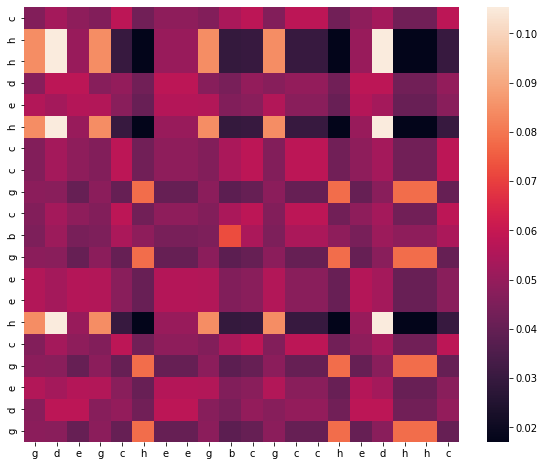

In [263]:
plt.figure(figsize=(10, 8))

decoded_seq = [string.ascii_lowercase[id] for id in seq]

ax = seaborn.heatmap(
    attention_map, 
    square=True, 
    xticklabels=decoded_seq, 
    yticklabels=decoded_seq
)

ax.invert_yaxis()

plt.show()